# **TECNICATURA UNIVERSITARIA EN INTELIGENCIA ARTIFICIAL**
## TRABAJO PRÁCTICO N° 1: APRENDIZAJE AUTOMÁTICO II
### Rosito, Valentín - (R-4662/1)
### **Fecha Límite de Entrega:** 07/12/2025
### **Semestre:** 2° Semestre 2025

---

## 1. Configuración del Entorno

Este notebook implementa un asistente virtual RAG (Retrieval-Augmented Generation) que combina tres tipos de bases de datos:
- **Base Vectorial**: ChromaDB con sentence-transformers para búsquedas semánticas
- **Base Tabular**: Pandas para consultas sobre inventario y precios
- **Base de Grafos**: NetworkX para relaciones entre productos

### 1.1 Instalación de Dependencias

### 1.2 Importación de Librerías

In [2]:
import os
import json
import warnings
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import chromadb
from chromadb.config import Settings

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
print("✓ Librerías importadas correctamente")

### 1.3 Configuración de Rutas y Constantes

In [3]:
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
CHROMA_DB_DIR = PROCESSED_DATA_DIR / "chroma_db"

PRODUCTOS_CSV = RAW_DATA_DIR / "productos.csv"
FAQS_JSON = RAW_DATA_DIR / "faqs.json"
TICKETS_CSV = RAW_DATA_DIR / "tickets_soporte.csv"
MANUALES_DIR = RAW_DATA_DIR / "manuales_productos"
RESENAS_DIR = RAW_DATA_DIR / "resenas_usuarios"

COLLECTION_NAME = "electrodomesticos_docs"

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")

Base directory: /Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos
Data directory: /Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos/data


## 2. Base Vectorial - ChromaDB

Esta sección implementa la búsqueda semántica usando ChromaDB. ChromaDB utiliza automáticamente el modelo `all-MiniLM-L6-v2` para generar embeddings, por lo que no necesitamos cargar el modelo manualmente.

**Fuentes de información:**
- Manuales de productos
- FAQs
- Tickets de soporte
- Reseñas de usuarios

### 2.1 Inicialización de ChromaDB

In [10]:
# Inicializar ChromaDB (usa all-MiniLM-L6-v2 por defecto)
chroma_client = chromadb.Client(Settings(
    persist_directory=str(CHROMA_DB_DIR),
    anonymized_telemetry=False
))

print(f"ChromaDB inicializado")

# Crear o obtener colección
try:
    collection = chroma_client.get_collection(name=COLLECTION_NAME)
    print(f"\nColección '{COLLECTION_NAME}' cargada")
    print(f"  Documentos en colección: {collection.count()}")
except:
    collection = chroma_client.create_collection(
        name=COLLECTION_NAME,
        metadata={"description": "Documentación y contenido de electrodomésticos"}
    )
    print(f"\nColección '{COLLECTION_NAME}' creada")

ChromaDB inicializado

Colección 'electrodomesticos_docs' cargada
  Documentos en colección: 10165


### 2.2 Funciones de Carga de Documentos

In [11]:
def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50) -> List[str]:
    """
    Divide un texto en chunks con overlap para mejor contexto.
    
    Args:
        text: Texto a dividir
        chunk_size: Tamaño aproximado de cada chunk en caracteres
        overlap: Cantidad de caracteres que se solapan entre chunks
    
    Returns:
        Lista de chunks de texto
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        if chunk:
            chunks.append(chunk)
    
    return chunks

def load_manuales() -> List[Dict[str, Any]]:
    """Carga todos los manuales de productos."""
    documentos = []
    
    if not MANUALES_DIR.exists():
        print(f"Directorio de manuales no encontrado: {MANUALES_DIR}")
        return documentos
    
    for manual_file in MANUALES_DIR.glob("*.md"):
        try:
            with open(manual_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = manual_file.stem.split('_')[1] if '_' in manual_file.stem else "unknown"
            
            # Dividir en chunks
            chunks = chunk_text(contenido, chunk_size=500, overlap=50)
            
            for idx, chunk in enumerate(chunks):
                documentos.append({
                    'id': f"manual_{product_id}_chunk_{idx}",
                    'text': chunk,
                    'metadata': {
                        'tipo': 'manual',
                        'producto_id': product_id,
                        'archivo': manual_file.name,
                        'chunk': idx
                    }
                })
        except Exception as e:
            print(f"Error cargando {manual_file.name}: {e}")
    
    return documentos

def load_faqs() -> List[Dict[str, Any]]:
    """Carga las FAQs desde el archivo JSON."""
    documentos = []
    
    if not FAQS_JSON.exists():
        print(f"⚠ Archivo FAQs no encontrado: {FAQS_JSON}")
        return documentos
    
    try:
        with open(FAQS_JSON, 'r', encoding='utf-8') as f:
            faqs = json.load(f)
        
        for idx, faq in enumerate(faqs):
            # Combinar pregunta y respuesta
            texto = f"Pregunta: {faq.get('pregunta', '')}\nRespuesta: {faq.get('respuesta', '')}"
            
            documentos.append({
                'id': f"faq_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'faq',
                    'categoria': faq.get('categoria', 'general')
                }
            })
    except Exception as e:
        print(f"Error cargando FAQs: {e}")
    
    return documentos

def load_tickets() -> List[Dict[str, Any]]:
    """Carga los tickets de soporte."""
    documentos = []
    
    if not TICKETS_CSV.exists():
        print(f"Archivo tickets no encontrado: {TICKETS_CSV}")
        return documentos
    
    try:
        df_tickets = pd.read_csv(TICKETS_CSV)
        
        for idx, row in df_tickets.iterrows():
            # Combinar problema y solución
            texto = f"Problema: {row.get('problema', '')}\nSolución: {row.get('solucion', '')}"
            
            documentos.append({
                'id': f"ticket_{idx}",
                'text': texto,
                'metadata': {
                    'tipo': 'ticket',
                    'producto_id': row.get('id_producto', 'unknown'),
                    'estado': row.get('estado', 'unknown')
                }
            })
    except Exception as e:
        print(f"Error cargando tickets: {e}")
    
    return documentos

def load_resenas() -> List[Dict[str, Any]]:
    """Carga las reseñas de usuarios."""
    documentos = []
    
    if not RESENAS_DIR.exists():
        print(f" Directorio de reseñas no encontrado: {RESENAS_DIR}")
        return documentos
    
    for resena_file in RESENAS_DIR.glob("*.txt"):
        try:
            with open(resena_file, 'r', encoding='utf-8') as f:
                contenido = f.read()
            
            # Extraer ID del producto del nombre del archivo
            product_id = resena_file.stem.replace('resenas_', '')
            
            documentos.append({
                'id': f"resena_{product_id}",
                'text': contenido,
                'metadata': {
                    'tipo': 'resena',
                    'producto_id': product_id
                }
            })
        except Exception as e:
            print(f"Error cargando {resena_file.name}: {e}")
    
    return documentos

### 2.3 Carga de Documentos en ChromaDB

In [12]:
def populate_vector_db():
    """Carga todos los documentos en ChromaDB."""
    
    # Cargar todos los documentos
    all_docs = []
    
    print("\n1. Cargando manuales...")
    manuales = load_manuales()
    print(f"   {len(manuales)} chunks de manuales cargados")
    all_docs.extend(manuales)
    
    print("\n2. Cargando FAQs...")
    faqs = load_faqs()
    print(f"   {len(faqs)} FAQs cargadas")
    all_docs.extend(faqs)
    
    print("\n3. Cargando tickets de soporte...")
    tickets = load_tickets()
    print(f"   {len(tickets)} tickets cargados")
    all_docs.extend(tickets)
    
    print("\n4. Cargando reseñas...")
    resenas = load_resenas()
    print(f"   {len(resenas)} reseñas cargadas")
    all_docs.extend(resenas)
    
    if not all_docs:
        print("No se encontraron documentos para cargar")
        return
    
    print(f"\nTotal de documentos: {len(all_docs)}")
    
    # Preparar datos para ChromaDB
    ids = [doc['id'] for doc in all_docs]
    texts = [doc['text'] for doc in all_docs]
    metadatas = [doc['metadata'] for doc in all_docs]
    
    # ChromaDB genera automáticamente los embeddings usando all-MiniLM-L6-v2
    print("\nInsertando documentos en ChromaDB...")
    print("(ChromaDB generará los embeddings automáticamente)")
    
    batch_size = 100
    for i in range(0, len(all_docs), batch_size):
        batch_end = min(i + batch_size, len(all_docs))
        
        collection.add(
            ids=ids[i:batch_end],
            documents=texts[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )
        
        print(f"  Procesados {batch_end}/{len(all_docs)} documentos")
        
    print(f"\n✓ Base vectorial poblada exitosamente")
    print(f"  Total documentos en colección: {collection.count()}")

# Poblar la base de datos vectorial (ejecutar solo si la colección está vacía)
if collection.count() == 0:
    populate_vector_db()
else:
    print(f"✓ Base vectorial ya contiene {collection.count()} documentos")
    print("  Para recargar, elimina la colección primero")

✓ Base vectorial ya contiene 10165 documentos
  Para recargar, elimina la colección primero


### 2.4 Función de Búsqueda Semántica

In [13]:
def semantic_search(query: str, n_results: int = 5, filter_tipo: Optional[str] = None) -> Dict[str, Any]:
    """
    Realiza búsqueda semántica en la base vectorial.
    ChromaDB genera automáticamente el embedding de la query usando all-MiniLM-L6-v2.
    
    Args:
        query: Consulta del usuario
        n_results: Número de resultados a retornar
        filter_tipo: Filtrar por tipo de documento ('manual', 'faq', 'ticket', 'resena')
    
    Returns:
        Dict con resultados de la búsqueda
    """
    # Preparar filtro si es necesario
    where_clause = {"tipo": filter_tipo} if filter_tipo else None
    
    # ChromaDB genera automáticamente el embedding de la query
    results = collection.query(
        query_texts=[query],
        n_results=n_results,
        where=where_clause
    )
    
    # Formatear resultados
    formatted_results = {
        'query': query,
        'n_results': len(results['ids'][0]),
        'documents': []
    }
    
    for i in range(len(results['ids'][0])):
        formatted_results['documents'].append({
            'id': results['ids'][0][i],
            'text': results['documents'][0][i],
            'metadata': results['metadatas'][0][i],
            'distance': results['distances'][0][i] if 'distances' in results else None
        })
    
    return formatted_results

## 3. Base Tabular - Pandas DataFrame

Esta sección implementa consultas estructuradas sobre el inventario de productos:
- Filtrado por precio, stock, categoría
- Comparación de productos
- Análisis de disponibilidad

### 3.1 Carga del DataFrame de Productos

In [14]:
df_productos = pd.read_csv(PRODUCTOS_CSV)

print(f"{len(df_productos)} productos cargados")
print(f"\nColumnas disponibles:")
for col in df_productos.columns:
    print(f"  - {col}")

print(f"\nEjemplo de productos:")
df_productos.head(3)

300 productos cargados

Columnas disponibles:
  - id_producto
  - nombre
  - categoria
  - subcategoria
  - marca
  - precio_usd
  - stock
  - color
  - potencia_w
  - capacidad
  - voltaje
  - peso_kg
  - garantia_meses
  - descripcion

Ejemplo de productos:


,id_producto,nombre,categoria,subcategoria,marca,precio_usd,stock,color,potencia_w,capacidad,voltaje,peso_kg,garantia_meses,descripcion
0,P0001,Licuadora,Cocina,Preparación,TechHome,283.63,108,Blanco,650.0,1.2L,12V,5.6,36,"Descubrí el poder de la Licuadora de TechHome,..."
1,P0002,Licuadora,Cocina,Preparación,TechHome,1273.06,114,Rosa,300.0,2.0L,220V,35.9,36,"Descubrí el poder de la Licuadora de TechHome,..."
2,P0003,Plus Licuadora Pro,Cocina,Preparación,TechHome,329.07,97,Negro,700.0,1.2L,220V,47.9,18,Descubrí el poder de la Plus Licuadora Pro de ...


### 3.2 Análisis Exploratorio del DataFrame

INFORMACIÓN DEL DATASET
Total de productos: 300
Categorías: 4
Marcas: 17


DISTRIBUCIÓN POR CATEGORÍA
categoria
Cocina           147
Climatización     81
Lavado            70
Audio y Video      2
Name: count, dtype: int64


ESTADÍSTICAS DE PRECIOS (USD)
count     300.000000
mean     1481.669567
std       845.525639
min        28.220000
25%       836.260000
50%      1409.915000
75%      2142.560000
max      2992.330000
Name: precio_usd, dtype: float64


ESTADÍSTICAS DE STOCK
count    300.000000
mean      99.950000
std       58.354534
min        1.000000
25%       48.250000
50%      100.000000
75%      150.000000
max      200.000000
Name: stock, dtype: float64


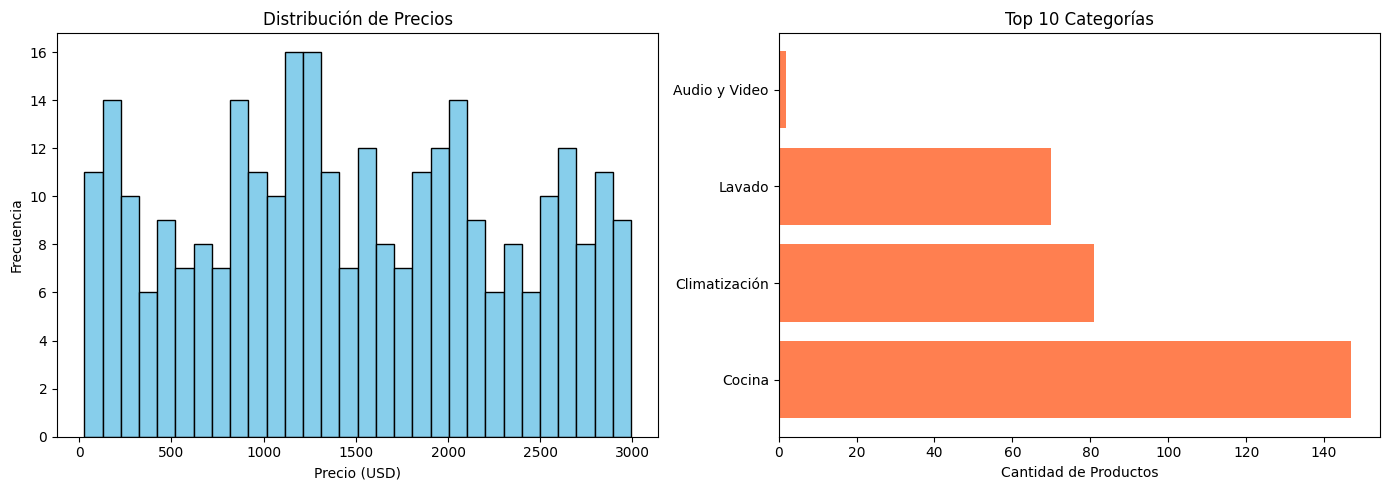

In [15]:
# Información del DataFrame
print("INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Total de productos: {len(df_productos)}")
print(f"Categorías: {df_productos['categoria'].nunique()}")
print(f"Marcas: {df_productos['marca'].nunique()}")

print("\n\nDISTRIBUCIÓN POR CATEGORÍA")
print("=" * 60)
print(df_productos['categoria'].value_counts())

print("\n\nESTADÍSTICAS DE PRECIOS (USD)")
print("=" * 60)
print(df_productos['precio_usd'].describe())

print("\n\nESTADÍSTICAS DE STOCK")
print("=" * 60)
print(df_productos['stock'].describe())

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de precios
axes[0].hist(df_productos['precio_usd'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Precios')
axes[0].set_xlabel('Precio (USD)')
axes[0].set_ylabel('Frecuencia')

# Top 10 categorías
top_categorias = df_productos['categoria'].value_counts().head(10)
axes[1].barh(range(len(top_categorias)), top_categorias.values, color='coral')
axes[1].set_yticks(range(len(top_categorias)))
axes[1].set_yticklabels(top_categorias.index)
axes[1].set_title('Top 10 Categorías')
axes[1].set_xlabel('Cantidad de Productos')

plt.tight_layout()
plt.show()

In [16]:
df_productos.groupby('categoria')['precio_usd'].mean().sort_values(ascending=False)

categoria
Climatización    1599.313704
Lavado           1509.291429
Cocina           1412.248776
Audio y Video     852.745000
Name: precio_usd, dtype: float64

### 3.2.1 Análisis de Variables Categóricas y Continuas
----
> Variables como `capacidad` y `voltaje` son strings conformadas en este formato (30L, 220V) respectivamente. O algunos casos en `voltaje` donde algun registro está en el formato: "110-220V".

In [28]:
resumen = {
    'CATEGÓRICAS': {},
    'CONTINUAS': {}
}

for var in ['categoria', 'subcategoria', 'marca', 'color', 'voltaje', 'capacidad']:
    if var in df_productos.columns:
        valores = sorted([str(v) for v in df_productos[var].unique() if pd.notna(v)])
        resumen['CATEGÓRICAS'][var] = valores

for var in ['precio_usd', 'stock', 'potencia_w', 'peso_kg', 'garantia_meses']:
    if var in df_productos.columns:
        valores = df_productos[var].dropna()
        if len(valores) > 0:
            resumen['CONTINUAS'][var] = {
                'min': valores.min(),
                'mediana': valores.median(),
                'max': valores.max()
            }

print("\n📊 VARIABLES CATEGÓRICAS:")
print("─" * 80)
for var, valores in resumen['CATEGÓRICAS'].items():
    print(f"\n{var}: ({len(valores)} valores únicos)")
    print(f"  {', '.join(valores[:10])}")
    if len(valores) > 10:
        print(f"  ... y {len(valores) - 10} más")

print("\n\n📈 VARIABLES CONTINUAS:")
print("─" * 80)
for var, stats in resumen['CONTINUAS'].items():
    print(f"\n{var}:")
    print(f"  Mínimo: {stats['min']:,.2f} | Mediana: {stats['mediana']:,.2f} | Máximo: {stats['max']:,.2f}")


📊 VARIABLES CATEGÓRICAS:
────────────────────────────────────────────────────────────────────────────────

categoria: (4 valores únicos)
  Audio y Video, Climatización, Cocina, Lavado

subcategoria: (13 valores únicos)
  Aires Acondicionados, Calefacción, Cocción, Lavado de Ropa, Lavado de Vajilla, Pequeños Electrodomésticos, Planchado, Preparación, Purificación, Refrigeración
  ... y 3 más

marca: (17 valores únicos)
  AirFlow, ChefMaster, CleanMaster, ClimaTech, CookElite, EcoClima, FreshWash, HomeChef, KitchenPro, LaundryTech
  ... y 7 más

color: (10 valores únicos)
  Amarillo, Azul, Blanco, Dorado, Gris, Negro, Plateado, Rojo, Rosa, Verde


📈 VARIABLES CONTINUAS:
────────────────────────────────────────────────────────────────────────────────

precio_usd:
  Mínimo: 28.22 | Mediana: 1,409.91 | Máximo: 2,992.33

stock:
  Mínimo: 1.00 | Mediana: 100.00 | Máximo: 200.00

potencia_w:
  Mínimo: 40.00 | Mediana: 1,050.00 | Máximo: 1,950.00

peso_kg:
  Mínimo: 0.60 | Mediana: 23.45 | Máx

### 3.2.2 Contexto y almacenamiento para LLM

In [48]:
schema_metadata = {
    "nombre_dataset": "Productos de Electrodomésticos",
    "total_registros": len(df_productos),
    "columnas": list(df_productos.columns),
    
    "variables_categoricas": {},
    "variables_continuas": {},
    
    "descripcion_general": "Base de datos de productos electrodomésticos con información de precios, stock, características técnicas y disponibilidad."
}


variables_categoricas = ['categoria', 'subcategoria', 'marca', 'color', 'voltaje', 'capacidad']

for var in variables_categoricas:
    if var in df_productos.columns:
        valores_unicos = sorted([str(v) for v in df_productos[var].unique() if pd.notna(v)])
        freq = df_productos[var].value_counts()
        
        schema_metadata["variables_categoricas"][var] = {
            "tipo": "categorical",
            "valores_unicos": valores_unicos,
            "cantidad_valores": len(valores_unicos),
        }


variables_continuas = ['precio_usd', 'stock', 'potencia_w', 'peso_kg', 'garantia_meses']

for var in variables_continuas:
    if var in df_productos.columns:
        valores = df_productos[var].dropna()
        
        if valores.dtype == 'object':
            valores = pd.to_numeric(valores, errors='coerce').dropna()
        
        if len(valores) > 0:
            schema_metadata["variables_continuas"][var] = {
                "tipo": "numeric",
                "minimo": float(valores.min()),
                "maximo": float(valores.max()),
                "mediana": float(valores.median()),
            }


# Crear directorio si no existe
metadata_dir = PROCESSED_DATA_DIR / "metadata"
metadata_dir.mkdir(parents=True, exist_ok=True)

# Guardar en JSON
metadata_file = metadata_dir / "schema_metadata.json"
with open(metadata_file, 'w', encoding='utf-8') as f:
    json.dump(schema_metadata, f, indent=2, ensure_ascii=False)

print("Metadatos del schema guardados exitosamente")
print("-"*60)
print(f"  Ubicación: {metadata_file}")
print(f"  Cantidad de tokens: {len(str(schema_metadata)) // 3}")
print(f"\nResumen:")
print(f"  - Variables categóricas: {len(schema_metadata['variables_categoricas'])}")
print(f"  - Variables continuas: {len(schema_metadata['variables_continuas'])}")
print(f"  - Total registros: {schema_metadata['total_registros']}")
print("-" * 80)

Metadatos del schema guardados exitosamente
------------------------------------------------------------
  Ubicación: /Users/valentinrosito/Downloads/Facultad/4to Cuatri/NLP/nlp-rag-agent-electrodomesticos/data/processed/metadata/schema_metadata.json
  Cantidad de tokens: 718

Resumen:
  - Variables categóricas: 6
  - Variables continuas: 5
  - Total registros: 300
--------------------------------------------------------------------------------


> En este caso, almacené en un JSON la siguiente información sobre la **base de datos tabular**:
- nombre_dataset: nombre del dataset (string).
- total_registros: cantidad total de filas en df_productos (int).
- columnas: lista con los nombres de las columnas del DataFrame (lista de strings).
- descripcion_general: descripción textual del dataset.


**variables_categoricas**: objeto donde cada variable categórica (ej. categoria, subcategoria, marca, color, voltaje, capacidad) tiene:

    - tipo: "categorical"
    - valores_unicos: lista ordenada de valores únicos (strings)
    - cantidad_valores: número de valores únicos (int)

**variables_continuas**: objeto donde cada variable numérica (ej. precio_usd, stock, potencia_w, peso_kg, garantia_meses) tiene:

    - tipo: "numeric"
    - minimo: valor mínimo (float)
    - maximo: valor máximo (float)
    - mediana: mediana (float)

> Decidí mantener este contexto **(≈700 tokens)** porque, comparado con la **ventana de contexto de Gemini 2.0 Flash (≈1,000,000 tokens)**, es insignificante y útil para el LLM.

---


## **Estrategia de Consulta con LLM:**

El LLM recibirá dos contextos:
1. **Schema del dataset** (`schema_context_for_llm.txt`): Información sobre variables categóricas y numéricas (Convertido del JSON creado previamente)
2. **Funciones disponibles** (`funciones_disponibles_for_llm.txt`): Especificación de las 8 funciones disponibles con ejemplos de JSON

El LLM analizará la consulta del usuario y retornará un JSON con:
- `funcion`: nombre de la función a ejecutar
- `parametros`: diccionario con los parámetros a pasar

Este enfoque permite que el LLM actúe como un **router inteligente** que traduce lenguaje natural a llamadas de función estructuradas.

In [44]:
def get_schema_metadata_for_llm() -> str:
    """
    Retorna los metadatos del schema en formato texto optimizado para LLM.
    Este contexto será usado por el LLM para elegir qué función llamar.
    
    Returns:
        String con la descripción completa del schema para contexto del LLM
    """
    
    prompt_text = f"""# SCHEMA DE BASE DE DATOS DE PRODUCTOS

## Información General
- Dataset: {schema_metadata['nombre_dataset']}
- Total de registros: {schema_metadata['total_registros']}
- Descripción: {schema_metadata['descripcion_general']}

## Columnas Disponibles
{', '.join(schema_metadata['columnas'])}

## Variables Categóricas

"""
    
    for var, info in schema_metadata['variables_categoricas'].items():
        prompt_text += f"### {var}\n"
        prompt_text += f"- Tipo: Categórica\n"
        prompt_text += f"- Valores únicos: {info['cantidad_valores']}\n"
        prompt_text += f"- Valores posibles: {', '.join(info['valores_unicos'][:20])}"
        if len(info['valores_unicos']) > 20:
            prompt_text += f" (y {len(info['valores_unicos']) - 20} más)"
        prompt_text += "\n\n"
    
    prompt_text += "## Variables Numéricas\n\n"
    
    for var, info in schema_metadata['variables_continuas'].items():
        prompt_text += f"### {var}\n"
        prompt_text += f"- Tipo: Numérica\n"
        prompt_text += f"- Rango: [{info['minimo']:.2f}, {info['maximo']:.2f}]\n"
        prompt_text += f"- Mediana: {info['mediana']:.2f}\n\n"
    
    return prompt_text


def get_funciones_disponibles_for_llm() -> str:
    """
    Retorna la documentación de las funciones disponibles para que el LLM 
    pueda elegir cuál usar y con qué parámetros.
    
    Returns:
        String con la especificación de las funciones disponibles
    """
    
    funciones_spec = """
# FUNCIONES DISPONIBLES PARA CONSULTAR PRODUCTOS

Tu tarea es analizar la consulta del usuario y devolver un JSON con la función apropiada y sus parámetros.

## Funciones Disponibles:

### 1. buscar_por_precio
**Descripción**: Busca productos por rango de precio y opcionalmente por categoría.
**Parámetros**:
- precio_min (float, opcional): Precio mínimo en USD
- precio_max (float, opcional): Precio máximo en USD  
- categoria (string, opcional): Categoría del producto
**Ejemplo JSON**:
{
  "funcion": "buscar_por_precio",
  "parametros": {
    "precio_min": 100.0,
    "precio_max": 500.0,
    "categoria": "Refrigeración"
  }
}

### 2. buscar_por_stock
**Descripción**: Busca productos con stock disponible.
**Parámetros**:
- stock_min (int, opcional, default=0): Stock mínimo requerido
- categoria (string, opcional): Categoría del producto
**Ejemplo JSON**:
{
  "funcion": "buscar_por_stock",
  "parametros": {
    "stock_min": 5,
    "categoria": "Cocina"
  }
}

### 3. buscar_por_caracteristicas
**Descripción**: Busca productos por características específicas.
**Parámetros**:
- marca (string, opcional): Marca del producto
- categoria (string, opcional): Categoría
- subcategoria (string, opcional): Subcategoría
- color (string, opcional): Color del producto
**Ejemplo JSON**:
{
  "funcion": "buscar_por_caracteristicas",
  "parametros": {
    "marca": "Samsung",
    "categoria": "Refrigeración",
    "color": "Plateado"
  }
}

### 4. comparar_productos
**Descripción**: Compara múltiples productos lado a lado.
**Parámetros**:
- ids_productos (lista de strings): Lista de IDs de productos a comparar
**Ejemplo JSON**:
{
  "funcion": "comparar_productos",
  "parametros": {
    "ids_productos": ["P0001", "P0002", "P0003"]
  }
}

### 5. productos_mas_baratos
**Descripción**: Retorna los n productos más baratos.
**Parámetros**:
- n (int, opcional, default=10): Número de productos a retornar
- categoria (string, opcional): Filtrar por categoría
**Ejemplo JSON**:
{
  "funcion": "productos_mas_baratos",
  "parametros": {
    "n": 5,
    "categoria": "Limpieza"
  }
}

### 6. productos_mas_caros
**Descripción**: Retorna los n productos más caros.
**Parámetros**:
- n (int, opcional, default=10): Número de productos a retornar
- categoria (string, opcional): Filtrar por categoría
**Ejemplo JSON**:
{
  "funcion": "productos_mas_caros",
  "parametros": {
    "n": 5,
    "categoria": "Climatización"
  }
}

### 7. obtener_categorias
**Descripción**: Retorna lista de todas las categorías disponibles.
**Parámetros**: Ninguno
**Ejemplo JSON**:
{
  "funcion": "obtener_categorias",
  "parametros": {}
}

### 8. obtener_marcas
**Descripción**: Retorna lista de todas las marcas disponibles.
**Parámetros**: Ninguno
**Ejemplo JSON**:
{
  "funcion": "obtener_marcas",
  "parametros": {}
}

## INSTRUCCIONES IMPORTANTES:

1. Analiza cuidadosamente la consulta del usuario
2. Elige UNA SOLA función que mejor responda a la consulta
3. Extrae los parámetros relevantes de la consulta
4. Devuelve ÚNICAMENTE un JSON válido con el formato:
   {
     "funcion": "nombre_funcion",
     "parametros": { ... }
   }
5. Si un parámetro no se menciona en la consulta, NO lo incluyas en el JSON
6. Para categorías, usa los valores exactos disponibles en el schema
7. Para precios, extrae los números mencionados en la consulta
"""
    
    return funciones_spec

In [46]:
# Generar contextos para el LLM
llm_schema_context = get_schema_metadata_for_llm()
llm_funciones_context = get_funciones_disponibles_for_llm()

# Guardar ambos contextos
context_file_schema = metadata_dir / "schema_context_for_llm.txt"
with open(context_file_schema, 'w', encoding='utf-8') as f:
    f.write(llm_schema_context)

context_file_funciones = metadata_dir / "funciones_disponibles_for_llm.txt"
with open(context_file_funciones, 'w', encoding='utf-8') as f:
    f.write(llm_funciones_context)

print(f"\nArchivo 1: Schema del Dataset")
print(f"  Tamaño: {len(llm_schema_context)} caracteres (~{len(llm_schema_context)//3} tokens)")

print(f"\nArchivo 2: Funciones Disponibles")
print(f"  Tamaño: {len(llm_funciones_context)} caracteres (~{len(llm_funciones_context)//3} tokens)")


Archivo 1: Schema del Dataset
  Tamaño: 1942 caracteres (~647 tokens)

Archivo 2: Funciones Disponibles
  Tamaño: 3326 caracteres (~1108 tokens)


### 3.3 Funciones de Consulta Tabular

In [49]:
def buscar_por_precio(precio_min: float = None, precio_max: float = None, 
                      categoria: str = None) -> pd.DataFrame:
    """
    Busca productos por rango de precio y opcionalmente por categoría.
    
    Args:
        precio_min: Precio mínimo
        precio_max: Precio máximo
        categoria: Categoría de producto
    
    Returns:
        DataFrame con productos filtrados
    """
    df = df_productos.copy()
    
    if precio_min is not None:
        df = df[df['precio_usd'] >= precio_min]
    
    if precio_max is not None:
        df = df[df['precio_usd'] <= precio_max]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.sort_values('precio_usd')

def buscar_por_stock(stock_min: int = 0, categoria: str = None) -> pd.DataFrame:
    """
    Busca productos con stock disponible.
    
    Args:
        stock_min: Stock mínimo requerido
        categoria: Categoría de producto
    
    Returns:
        DataFrame con productos con stock
    """
    df = df_productos[df_productos['stock'] >= stock_min]

    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.sort_values('stock', ascending=False)

def buscar_por_caracteristicas(marca: str = None, categoria: str = None, 
                               subcategoria: str = None, color: str = None) -> pd.DataFrame:
    """
    Busca productos por características específicas.
    
    Args:
        marca: Marca del producto
        categoria: Categoría
        subcategoria: Subcategoría
        color: Color del producto
    
    Returns:
        DataFrame con productos que cumplen los criterios
    """
    df = df_productos.copy()
    
    if marca is not None:
        df = df[df['marca'].str.contains(marca, case=False, na=False)]
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    if subcategoria is not None:
        df = df[df['subcategoria'].str.contains(subcategoria, case=False, na=False)]
    
    if color is not None:
        df = df[df['color'].str.contains(color, case=False, na=False)]
    
    return df

def comparar_productos(ids_productos: List[str]) -> pd.DataFrame:
    """
    Compara múltiples productos lado a lado.
    
    Args:
        ids_productos: Lista de IDs de productos a comparar
    
    Returns:
        DataFrame con comparación de productos
    """
    df = df_productos[df_productos['id_producto'].isin(ids_productos)]
    
    columnas_importantes = ['id_producto', 'nombre', 'marca', 'precio_usd', 
                           'stock', 'potencia_w', 'capacidad', 'garantia_meses']
    
    # Seleccionar solo columnas que existen
    columnas_existentes = [col for col in columnas_importantes if col in df.columns]
    
    return df[columnas_existentes].T

def productos_mas_baratos(n: int = 10, categoria: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más baratos.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
    
    Returns:
        DataFrame con los productos más baratos
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.nsmallest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def productos_mas_caros(n: int = 10, categoria: str = None) -> pd.DataFrame:
    """
    Retorna los n productos más caros.
    
    Args:
        n: Número de productos a retornar
        categoria: Filtrar por categoría (opcional)
    
    Returns:
        DataFrame con los productos más caros
    """
    df = df_productos.copy()
    
    if categoria is not None:
        df = df[df['categoria'].str.contains(categoria, case=False, na=False)]
    
    return df.nlargest(n, 'precio_usd')[['id_producto', 'nombre', 'marca', 'precio_usd', 'stock']]

def obtener_categorias() -> List[str]:
    """Retorna lista de todas las categorías disponibles."""
    return sorted(df_productos['categoria'].unique().tolist())

def obtener_marcas() -> List[str]:
    """Retorna lista de todas las marcas disponibles."""
    return sorted(df_productos['marca'].unique().tolist())

### 3.4 Interfaz para Consultas con LLM

Esta interfaz permite que un LLM interprete consultas en lenguaje natural y las traduzca a llamadas de función estructuradas.

In [ ]:
!pip install langchain

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain


def crear_prompt_llm_template(schema_context: str = llm_schema_context,
                                funciones_context: str = llm_funciones_context) -> PromptTemplate:
    """
    Construye un PromptTemplate donde sólo `consulta_usuario` será variable
    al invocarlo.

    Usa las variables `llm_schema_context` y `llm_funciones_context` definidas
    en el notebook para fijar el contexto del prompt.
    """
    template = f"""{schema_context}

---

{funciones_context}

---

## CONSULTA DEL USUARIO:
{{consulta_usuario}}

## TU RESPUESTA (SOLO JSON):
"""
    return PromptTemplate(input_variables=["consulta_usuario"], template=template)


def crear_llm_chain(llm) -> LLMChain:
    """
    Crea y retorna un LLMChain listo para ejecutar. Recibe un objeto `llm`
    compatible con LangChain (por ejemplo OpenAI, HuggingFace, etc.).
    """
    prompt = crear_prompt_llm_template()
    return LLMChain(llm=llm, prompt=prompt)


def invocar_llm_con_consulta(llm, consulta_usuario: str) -> str:
    """
    Helper que crea el chain y ejecuta la consulta.
    Retorna el texto devuelto por el LLM (puede ser JSON en texto).
    """
    chain = crear_llm_chain(llm)
    return chain.run({"consulta_usuario": consulta_usuario})


In [ ]:
FUNCIONES_DISPONIBLES = {
    'buscar_por_precio': buscar_por_precio,
    'buscar_por_stock': buscar_por_stock,
    'buscar_por_caracteristicas': buscar_por_caracteristicas,
    'comparar_productos': comparar_productos,
    'productos_mas_baratos': productos_mas_baratos,
    'productos_mas_caros': productos_mas_caros,
    'obtener_categorias': obtener_categorias,
    'obtener_marcas': obtener_marcas
}

def ejecutar_consulta_tabular(funcion_json: Dict[str, Any]) -> Any:
    """
    Ejecuta una consulta tabular basada en el JSON retornado por el LLM.

    Returns:
        Resultado de la función (generalmente un DataFrame)
    
    Raises:
        ValueError: Si la función no existe o hay errores en los parámetros
    """
    # Validar estructura del JSON
    if not isinstance(funcion_json, dict):
        raise ValueError("El input debe ser un diccionario")
    
    if 'funcion' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'funcion'")
    
    if 'parametros' not in funcion_json:
        raise ValueError("El JSON debe contener la key 'parametros'")
    
    nombre_funcion = funcion_json['funcion']
    parametros = funcion_json['parametros']
    
    # Validar que la función existe
    if nombre_funcion not in FUNCIONES_DISPONIBLES:
        funciones_validas = ', '.join(FUNCIONES_DISPONIBLES.keys())
        raise ValueError(
            f"Función '{nombre_funcion}' no encontrada. "
            f"Funciones disponibles: {funciones_validas}"
        )
    
    funcion = FUNCIONES_DISPONIBLES[nombre_funcion]
    
    try:
        resultado = funcion(**parametros)
        return resultado
    except TypeError as e:
        raise ValueError(f"Error en los parámetros de '{nombre_funcion}': {str(e)}")
    except Exception as e:
        raise ValueError(f"Error ejecutando '{nombre_funcion}': {str(e)}")


def consulta_con_llm_tabular(
    consulta_usuario: str) -> Any:
    """
    Interfaz principal para realizar consultas en lenguaje natural sobre la base tabular.
    
    Esta función:
    1. Prepara el contexto (schema + funciones disponibles) para el LLM
    2. Envía la consulta del usuario al LLM
    3. El LLM retorna un JSON con la función y parámetros
    4. Ejecuta la función correspondiente
    5. Retorna el resultado

    Devuelve:
        Resultado de la consulta (generalmente un DataFrame)
    """
    
    # 2. Llamar al LLM
    try:
        respuesta_llm = invocar_llm_con_consulta(consulta_usuario)
        # 3. Parsear JSON
        # El LLM puede retornar JSON en markdown (```json ... ```)
        respuesta_limpia = respuesta_llm.strip()
        
        # Limpiar markdown code blocks si existen
        if respuesta_limpia.startswith("```"):
            # Encontrar el contenido entre ``` y ```
            lineas = respuesta_limpia.split('\n')
            respuesta_limpia = '\n'.join(lineas[1:-1])
        
        funcion_json = json.loads(respuesta_limpia)

        # 4. Ejecutar la función
        resultado = ejecutar_consulta_tabular(funcion_json)
    
        return resultado
        
    except json.JSONDecodeError as e:
        raise ValueError(f"Error parseando JSON del LLM: {str(e)}\nRespuesta: {respuesta_llm}")
    except Exception as e:
        raise ValueError(f"Error en la consulta: {str(e)}")

### 3.4.1 Ejemplo de Integración con Google Gemini

A continuación se muestra cómo integrar la interfaz con diferentes LLMs.

In [ ]:
# EJEMPLO 1: Integración con Google Gemini (Recomendado para Colab)
# 
# Instalar: !pip install google-generativeai
# 
# import google.generativeai as genai
# 
# def consulta_con_gemini(consulta_usuario: str, api_key: str) -> pd.DataFrame:
#     """
#     Consulta usando Google Gemini 2.0 Flash.
#     
#     Args:
#         consulta_usuario: Consulta en lenguaje natural
#         api_key: API key de Google AI Studio
#     
#     Returns:
#         DataFrame con los resultados
#     """
#     # Configurar Gemini
#     genai.configure(api_key=api_key)
#     model = genai.GenerativeModel('gemini-2.0-flash-exp')
#     
#     # Función wrapper para el LLM
#     def llm_gemini(contexto_completo: str, consulta: str) -> str:
#         response = model.generate_content(contexto_completo)
#         return response.text
#     
#     # Usar la interfaz
#     return consulta_con_llm_tabular(
#         consulta_usuario=consulta_usuario,
#         llm_function=llm_gemini,
#         verbose=True
#     )
# 
# # USO:
# # GEMINI_API_KEY = "tu-api-key-aqui"  # Obtener en https://aistudio.google.com/
# # resultado = consulta_con_gemini("Muéstrame los 5 refrigeradores más baratos", GEMINI_API_KEY)
# # display(resultado)


# EJEMPLO 2: Simulación para testing (sin API)
def llm_simulado(contexto: str, consulta: str) -> str:
    """
    LLM simulado para testing sin usar APIs reales.
    En producción, reemplazar por llamada real a Gemini/GPT/Claude.
    """
    # Este es un ejemplo hardcodeado para demostración
    # El LLM real analizaría la consulta y retornaría el JSON apropiado
    
    consulta_lower = consulta.lower()
    
    if "baratos" in consulta_lower or "económicos" in consulta_lower:
        return """{
  "funcion": "productos_mas_baratos",
  "parametros": {
    "n": 5
  }
}"""
    
    elif "caros" in consulta_lower or "costosos" in consulta_lower:
        return """{
  "funcion": "productos_mas_caros",
  "parametros": {
    "n": 5
  }
}"""
    
    elif "stock" in consulta_lower or "disponible" in consulta_lower:
        return """{
  "funcion": "buscar_por_stock",
  "parametros": {
    "stock_min": 1
  }
}"""
    
    elif "precio" in consulta_lower:
        # Extraer números (simulación simple)
        import re
        numeros = re.findall(r'\d+', consulta)
        if len(numeros) >= 2:
            return f"""{{
  "funcion": "buscar_por_precio",
  "parametros": {{
    "precio_min": {float(numeros[0])},
    "precio_max": {float(numeros[1])}
  }}
}}"""
    
    # Default: productos más baratos
    return """{
  "funcion": "productos_mas_baratos",
  "parametros": {
    "n": 10
  }
}"""


print("✅ Ejemplos de integración con LLM configurados")
print("\n💡 Para usar con Gemini:")
print("   1. Descomenta el código del EJEMPLO 1")
print("   2. Obtén tu API key en https://aistudio.google.com/")
print("   3. Ejecuta: consulta_con_gemini('tu consulta', 'tu-api-key')")
print("\n🧪 Para testing sin API:")
print("   Usa: consulta_con_llm_tabular('tu consulta', llm_simulado)")

### 3.4.2 Pruebas de la Interfaz

Ejemplos de consultas en lenguaje natural.

In [ ]:
# Prueba 1: Productos más baratos
print("=" * 80)
print("PRUEBA 1: Productos más baratos")
print("=" * 80)

resultado1 = consulta_con_llm_tabular(
    consulta_usuario="Muéstrame los 5 productos más económicos",
    llm_function=llm_simulado,
    verbose=True
)

print("\n📊 Resultados:")
display(resultado1)

In [ ]:
# Prueba 2: Búsqueda por stock
print("=" * 80)
print("PRUEBA 2: Productos con stock disponible")
print("=" * 80)

resultado2 = consulta_con_llm_tabular(
    consulta_usuario="¿Qué productos tienen stock disponible?",
    llm_function=llm_simulado,
    verbose=True
)

print(f"\n📊 Resultados: {len(resultado2)} productos con stock")
display(resultado2.head(10))

In [ ]:
# Prueba 3: Prueba manual con JSON directo
print("=" * 80)
print("PRUEBA 3: Ejecución directa con JSON")
print("=" * 80)

# Simulación de lo que el LLM retornaría
json_ejemplo = {
    "funcion": "buscar_por_caracteristicas",
    "parametros": {
        "categoria": "Refrigeración",
        "marca": "Samsung"
    }
}

print(f"\n📥 JSON de entrada:")
print(json.dumps(json_ejemplo, indent=2, ensure_ascii=False))

resultado3 = ejecutar_consulta_tabular(json_ejemplo)

print(f"\n📊 Resultados: {len(resultado3)} productos encontrados")
display(resultado3.head())

### 3.4.3 Documentación de la Interfaz

#### **Arquitectura de la Interfaz**

```
┌─────────────────────────────────────────────────────────────┐
│                    USUARIO                                   │
│              Consulta en lenguaje natural                    │
└──────────────────────┬──────────────────────────────────────┘
                       │
                       ▼
┌─────────────────────────────────────────────────────────────┐
│              consulta_con_llm_tabular()                      │
│  • Prepara contexto (schema + funciones)                    │
│  • Envía al LLM                                              │
└──────────────────────┬──────────────────────────────────────┘
                       │
                       ▼
┌─────────────────────────────────────────────────────────────┐
│                    LLM (Gemini/GPT/Claude)                   │
│  • Recibe: contexto + consulta                               │
│  • Analiza la intención del usuario                          │
│  • Retorna: JSON con función y parámetros                    │
└──────────────────────┬──────────────────────────────────────┘
                       │
                       ▼
┌─────────────────────────────────────────────────────────────┐
│              ejecutar_consulta_tabular()                     │
│  • Valida el JSON                                            │
│  • Busca la función en FUNCIONES_DISPONIBLES                │
│  • Ejecuta con los parámetros                                │
└──────────────────────┬──────────────────────────────────────┘
                       │
                       ▼
┌─────────────────────────────────────────────────────────────┐
│                    RESULTADO                                 │
│              DataFrame con los productos                     │
└─────────────────────────────────────────────────────────────┘
```

#### **Ventajas de esta Arquitectura**

1. **Separación de Responsabilidades**: El LLM solo interpreta, no ejecuta código
2. **Seguridad**: Solo se pueden ejecutar funciones predefinidas
3. **Flexibilidad**: Fácil agregar nuevas funciones al diccionario
4. **Testing**: Se puede probar sin llamar al LLM (usando `llm_simulado`)
5. **Multi-LLM**: Compatible con cualquier LLM (Gemini, GPT-4, Claude, etc.)

#### **Cómo Agregar Nuevas Funciones**

```python
# 1. Define la función
def mi_nueva_funcion(param1: str, param2: int = 10) -> pd.DataFrame:
    # Tu lógica aquí
    return df_productos[df_productos['columna'] == param1]

# 2. Agrégala al diccionario
FUNCIONES_DISPONIBLES['mi_nueva_funcion'] = mi_nueva_funcion

# 3. Documéntala en get_funciones_disponibles_for_llm()
```

#### **Contexto Enviado al LLM**

El LLM recibe:
- **Schema del dataset**: Variables categóricas y numéricas con sus valores posibles
- **Funciones disponibles**: 8 funciones documentadas con ejemplos de JSON
- **Consulta del usuario**: Texto en lenguaje natural

Total: ~3,000 tokens (0.3% de la ventana de Gemini 2.0 Flash)

## 4. Base de Grafos - NetworkX

Esta sección implementa un grafo de relaciones entre productos:
- Productos compatibles
- Accesorios relacionados
- Productos similares por categoría/características
- Recomendaciones basadas en relaciones